In [51]:
import numpy as np
import matplotlib.pyplot as plt
import h5py, os, sys, glob, tqdm
import _pickle as pkl
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
recording_folder = '/Volumes/DATA7/autobahn/20210922_3591_ABC_g0'
stim_path      = os.path.join(recording_folder,'stim')
experimenter = 'djd'
experiment_description= 'for Hughes Lab collaboration on Autobahn Therepeutics remyelination therapy.'

# Pre-requisites:
- kilosort run on each probe
- phy curation, where some units marked good and some MUA 
- stimuli placed in a folder called 'stim' within each folder

### load stimulus information
this will be specific to each experimental paradigm. the below is for the autobahn stimulus.

In [53]:
glob.glob(stim_path+'/*gratings*')

['/Volumes/DATA7/autobahn/20210922_3591_ABC_g0/stim/210923110820-gratings_color-3591.pkl',
 '/Volumes/DATA7/autobahn/20210922_3591_ABC_g0/stim/210923103146-gratings_orientation-3591.pkl']

In [54]:
gratings_pkl = pkl.load(open(glob.glob(stim_path+'/*gratings*')[1],'rb'))
scene_pkl = pkl.load(open(glob.glob(stim_path+'/*scene*')[0],'rb'))
arbMatrixcolor_pkl = pkl.load(open(glob.glob(stim_path+'/*color_*')[0],'rb'))
arbMatrix_pkl = pkl.load(open(glob.glob(stim_path+'/*highspeed*')[0],'rb'))
arbMatrix_matrix = pkl.load(open(np.sort(glob.glob(stim_path+'/*'))[0],'rb'))
gratings_color_pkl = pkl.load(open(glob.glob(stim_path+'/*gratings*')[0],'rb'))

#stimulus list
stimuli = {'luminance_flash':None,
           'gratings':gratings_pkl,
           'gratings_color':gratings_color_pkl,
           'natural_scenes':scene_pkl,
           'spatiochromatic_noise':arbMatrixcolor_pkl,
            'spatioluminance_noise':arbMatrix_matrix}

parse stimulus information.
this currently takes ~2X recording time, for some reason. need to fix

In [55]:
if not os.path.exists(os.path.join(recording_folder,'digital_lines_rising_samples.pkl')):
    #spikeGLX. ignore this cell if data is from Open Ephys GUI 
    nidaq_bin = '/Volumes/s1/autobahn/20210922_3591_1_g0/20210922_3591_1_g0_t0.nidq.bin'
    mm = np.memmap(nidaq_bin,dtype=np.uint16)
    digital_words = mm[8::9]
    num_digital_channels=8 # TODO: update to get this from .meta file; from niXDChans
    digital_lines_rising = {}
    digital_lines_falling = {}
    for i in tqdm.tqdm(range(digital_words.shape[0])[::10]): #note that this downsamples by factor 10, to 100kHz
        if i==0:
            state_previous_sample = '{0:08b}'.format(digital_words[i])
            for line in range(num_digital_channels):
                digital_lines_rising['D'+str(line)] = [] #initialize empty list
                digital_lines_falling['D'+str(line)] = [] #initialize empty list
        else:
            state_this_sample = '{0:08b}'.format(digital_words[i])
            changes = [j for j in range(len(state_previous_sample)) if state_previous_sample[j] != state_this_sample[j]]
            for line in changes:   
                    if state_this_sample[line] == '1':
                        digital_lines_rising['D'+str(line)].extend([i*10]) #note that this scales back up to 1MHz sampling rate 
                    else:
                        digital_lines_falling['D'+str(line)].extend([i*10])  #note that this scales back up to 1MHz sampling rate 
            state_previous_sample=state_this_sample #update sample
    digital_lines_rising2 = {}
    digital_lines_falling2 = {}
    for i,key in enumerate(digital_lines_rising.keys()):
        digital_lines_rising2['D'+str(7-i)]=np.array(digital_lines_rising[key])/10000000.
        digital_lines_falling2['D'+str(7-i)]=np.array(digital_lines_falling[key])/10000000.
    pkl.dump(digital_lines_rising2,open(os.path.join(recording_folder,'digital_lines_rising_samples.pkl'),'wb'))
    pkl.dump(digital_lines_falling2,open(os.path.join(recording_folder,'digital_lines_falling_samples.pkl'),'wb'))
else:
    digital_lines_rising2 = pkl.load(open(os.path.join(recording_folder,'digital_lines_rising_samples.pkl'),'rb'))
    digital_lines_falling2= pkl.load(open(os.path.join(recording_folder,'digital_lines_falling_samples.pkl'),'rb'))

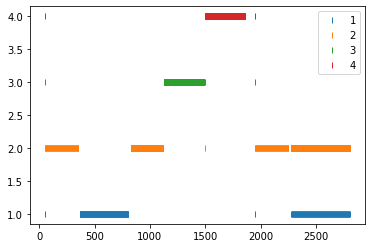

In [56]:
for ch in ([1,2,3,4]):
    plt.plot(np.array(digital_lines_rising2['D'+str(ch)]),
             np.ones(len(digital_lines_rising2['D'+str(ch)]))*ch,
             '|',label=ch)
plt.legend()

In [57]:
np.where(np.diff(digital_lines_rising2['D2'])>10.)[0][-1]

3152

In [58]:
len(stimuli['natural_scenes']['bgsweeporder'])

2950

In [59]:
flashes_times = digital_lines_rising2['D2'][1:np.where(np.diff(digital_lines_rising2['D2'])>50.)[0][0]+1]
gratings_times= digital_lines_rising2['D1'][1:221]
gratings_color_times= digital_lines_rising2['D1'][222:]
scenes_times= digital_lines_rising2['D2'][np.where(np.diff(digital_lines_rising2['D2'])>50.)[0][0]+1:np.where(np.diff(digital_lines_rising2['D2'])>50.)[0][1]+1]
highspeed_times = digital_lines_rising2['D3'][1:-2]
color_times = digital_lines_rising2['D4'][1:-1]
flashes_times2 = digital_lines_rising2['D2'][np.where(np.diff(digital_lines_rising2['D2'])>50.)[0][1]+3:np.where(np.diff(digital_lines_rising2['D2'])>10.)[0][-1]+1]


In [20]:
flashes_times2.shape

(100,)

In [23]:
if np.shape(color_times)[0]!=7200 \
    or np.shape(highspeed_times)[0]!=7200\
    or np.shape(scenes_times)[0]!=len(stimuli['natural_scenes']['bgsweeporder'])\
    or np.shape(gratings_times)[0]!=220\
    or np.shape(flashes_times)[0]!=100:
    print('problem. '+str(np.shape(highspeed_times)[0]))
else:
    stimuli_times = {'luminance_flash':flashes_times,
                       'gratings':gratings_times,
                       'natural_scenes':scenes_times,
                       'spatiochromatic_noise':color_times,
                        'spatioluminance_noise':highspeed_times,
                         'gratings_color':gratings_color_times}

### load sorted units

In [23]:
from dlab.nwbtools import df_from_phy, load_phy_template, option234_positions, multi_load_unit_data
import pandas as pd

no Allen Institute NWB API. get this from http://stash.corp.alleninstitute.org/projects/INF/repos/ainwb/browse
no OpenEphys.py get this from https://github.com/open-ephys/analysis-tools


In [60]:
#spikeglx
probes = [os.path.basename(f) for f in np.sort(glob.glob(recording_folder+'/*imec*'))]
probeids = ['B','C','A'] 
probedepths = [1124,1550,1000] 

In [25]:
unit_dfs = []
for i,probe in enumerate(probes[:2]):
    #make a units DataFrame
    units = load_phy_template(os.path.join(recording_folder,probe))
    df = pd.DataFrame.from_dict(units,orient='index')
    df['probe'] = [probeids[i]]*df.shape[0]
    df['depth'] = np.array(df['ypos']-3840)+probedepths[i]
    #waveform
    unit_dfs.extend([df])

In [26]:
df_units = pd.concat(unit_dfs)

In [27]:
df_units.head()

,samples,times,template,waveform_weights,xpos,ypos,label,KSlabel,KSamplitude,KScontamination,probe,depth
12,"[1886076, 2762024, 7572523, 7597413, 8071839, ...","[62.8692, 92.06746666666666, 252.4174333333333...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.396214...",31.836469,3673.461189,mua,mua,25.4,100.0,B,957.461189
20,"[606445, 612765, 614824, 615740, 623500, 62786...","[20.214833333333335, 20.4255, 20.4941333333333...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",33.837950,3580.033875,good,mua,22.3,100.0,B,864.033875
21,"[113971, 182136, 182297, 194229, 194458, 26163...","[3.7990333333333335, 6.0712, 6.076566666666666...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",35.024291,3563.096230,good,mua,27.4,100.0,B,847.096230
22,"[2872, 3112, 3405, 4652, 19315, 19803, 21341, ...","[0.09573333333333334, 0.10373333333333333, 0.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",26.080257,3554.855764,good,mua,17.0,100.0,B,838.855764
23,"[16781, 23273, 23585, 33350, 87334, 87707, 880...","[0.5593666666666667, 0.7757666666666667, 0.786...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...",10.163416,3522.595236,good,mua,19.4,100.0,B,806.595236


In [12]:
def mean_waveform(rawdata,times,pre=0.5,post=1.5,channels=384,sampling_rate=30000):
    rawdata = np.memmap(rawdata, dtype=np.int16, mode='r')
    rawdata = rawdata.reshape(385,-1)
    mean_waveform = []#np.zeros(channels,int((pre+post)*.001)*sampling_rate*channels)
    for i,ch in enumerate(np.linspace(0,channels-1,channels).astype(int)):
        try:
            w = load_waveforms(rawdata,ch,times,pre,post,channels,sampling_rate)
        except:
            w = np.zeros((len(times),int(((pre+post)/1000.)*sampling_rate)))
        mean_waveform.append(np.mean(w,axis=0))#[i,:]=np.mean(w).flatten()
    return mean_waveform

In [13]:
os.path.join('Volumes/s1/autobahn/20210818_3583_ABC_2_g0',probe)+"/*ap.b*"

'Volumes/s1/autobahn/20210818_3583_ABC_2_g0/20210818_3583_ABC_2_g0_imec1/*ap.b*'

In [14]:
rawdata = glob.glob(os.path.join('/Volumes/s1/autobahn/20210818_3583_ABC_2_g0',probe)+'/*ap.b*')[0]
rawdata = np.memmap(rawdata, dtype=np.int16, mode='r')
rawdata = rawdata.reshape(385,-1,order='f')

In [ ]:
plt.plot(rawdata[:1000,30])

In [ ]:
plt.imshow(rawdata[:1000,:])

In [ ]:
rawdata[:1000,:].T 

In [ ]:
np.array(rawdata[:1000,:]) - np.mean(rawdata[:1000,:].T,axis=1)

In [ ]:
plt.imshow(np.array(np.array(rawdata[:1000,:]) - np.mean(rawdata[:1000,:].T,axis=1)).T)

In [ ]:
u=9
if df_units[df_units.label=='good'].iloc[u].samples.shape[0]>200:
    samples = np.random.choice(df_units[df_units.label=='good'].iloc[u].samples,200)
else:
    samples = df_units[df_units.label=='good'].iloc[u].samples

In [ ]:
spikes = np.array([rawdata[sample:sample+82,:384] for sample in np.sort(samples).astype(int)])
# spikes = np.array([spikes[:,:,ch] - np.mean(spikes[:,:,ch]) for ch in range(384)])

In [ ]:
plt.figure(figsize=(4,20))
for i in range(384):
    plt.plot(spikes[0,:,i] - np.mean(spikes[0,:,i])+i*10)

In [ ]:
plt.imshow(spikes[:,:,ch])

In [ ]:
spike = np.mean(spikes,axis=1)

In [ ]:
plt.imshow(spike.T[::-1])

In [ ]:
if df_units[df_units.label=='good'].iloc[1].samples.shape[0]>200:
    samples = np.random.choice(df_units[df_units.label=='good'].iloc[1].samples,200)
else:
    samples = df_units[df_units.label=='good'].iloc[1].samples

In [ ]:
samples.shape

do unit quailty analysis; add to df

In [ ]:
# print('PCA quality took '+str(time.time()-t0)+' sec');t0 = time.time()
# isiV = sq.isiViolations(directory,time_limits)

## Assemble NWB

In [4]:
import pynwb
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.utils import StrDataset

In [33]:
from datetime import datetime
from dateutil.tz import tzlocal
from pynwb import NWBFile

nwbfile = NWBFile('Autobahn_myelin', 
                  recording_folder, 
                  datetime.now(tzlocal()),
                  experimenter=experimenter,
                  lab='Denman Lab',
                  institution='University of Colorado',
                  experiment_description=experiment_description,
                  session_id=os.path.basename(recording_folder))

### add stimulus information

In [34]:
stimuli_times.keys()

dict_keys(['luminance_flash', 'gratings', 'natural_scenes', 'spatiochromatic_noise', 'spatioluminance_noise', 'gratings_color'])

In [35]:
for stim in stimuli_times.keys():
    nwbfile.add_epoch(stimuli_times[stim][0], 
                      stimuli_times[stim][-1]+3.,
                      [stim])

In [36]:
nwbfile.add_trial_column('stimulus', 'the stimulus during this trial')
nwbfile.add_trial_column('stimulus_info', 'the stimulus descriptor')

lums = ['white','black']
stim = 'luminance_flash'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=[lums[i%2]])

stim = 'gratings'
info = [stimuli[stim]['bgsweeptable'][ind] for ind in stimuli[stim]['bgsweeporder']]
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=[info[i]])
stim = 'gratings_color'
info = [stimuli[stim]['bgsweeptable'][ind] for ind in stimuli[stim]['bgsweeporder']]
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=[info[i]])

stim = 'natural_scenes'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=[stimuli[stim]['bgsweeporder'][i]])

stim = 'spatiochromatic_noise'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=[stimuli['spatiochromatic_noise']['stackG'][i].tolist(),stimuli['spatiochromatic_noise']['stackB'][i].tolist()])

stim = 'spatioluminance_noise'
for i,trial_start in enumerate(stimuli_times[stim]):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start+np.mean(np.diff(stimuli_times[stim])), stimulus=stim,stimulus_info=stimuli['spatioluminance_noise'][i].tolist())

In [17]:
info

[(1, 0, 3, 0.08, 0, 0, 210),
 (1, 0, 3, 0.16, 0, 0, 120),
 (1, 0, 3, 0.16, 0, 0, 270),
 (1, 0, 3, 0.16, 0, 0, 60),
 (1, 0, 3, 0.08, 0, 0, 270),
 (1, 0, 3, 0.16, 0, 0, 300),
 (1, 0, 3, 0.08, 0, 0, 0),
 (1, 0, 3, 0.16, 0, 0, 90),
 (1, 0, 3, 0.08, 0, 0, 300),
 (1, 0, 3, 0.08, 0, 0, 270),
 (1, 0, 3, 0.08, 0, 0, 180),
 (1, 0, 3, 0.16, 0, 0, 60),
 (1, 0, 3, 0.16, 0, 0, 210),
 (1, 0, 3, 0.08, 0, 0, 60),
 (1, 0, 3, 0.08, 0, 0, 90),
 (1, 0, 3, 0.08, 0, 0, 240),
 (1, 0, 3, 0.08, 0, 0, 210),
 (1, 0, 3, 0.16, 0, 0, 90),
 (1, 0, 3, 0.16, 0, 0, 30),
 (1, 0, 3, 0.08, 0, 0, 240),
 (1, 0, 3, 0.08, 0, 0, 120),
 (1, 0, 3, 0.08, 0, 0, 120),
 (1, 0, 3, 0.16, 0, 0, 330),
 (1, 0, 3, 0.08, 0, 0, 60),
 (1, 0, 3, 0.08, 0, 0, 270),
 (1, 0, 3, 0.16, 0, 0, 60),
 (1, 0, 3, 0.16, 0, 0, 240),
 (1, 0, 3, 0.08, 0, 0, 180),
 (1, 0, 3, 0.16, 0, 0, 60),
 (1, 0, 3, 0.16, 0, 0, 180),
 (1, 0, 3, 0.08, 0, 0, 60),
 (1, 0, 3, 0.08, 0, 0, 30),
 (1, 0, 3, 0.08, 0, 0, 0),
 (1, 0, 3, 0.16, 0, 0, 0),
 (1, 0, 3, 0.08, 0, 0, 90),
 (1,

### add ephys data
first add electrodes and raw data link

In [37]:
probes = [os.path.basename(f) for f in np.sort(glob.glob(recording_folder+'/*imec*'))]
probeids = ['B','C','A'] 

In [38]:
device = nwbfile.create_device(name='DenmanLab_EphysRig1')
for i, probe in enumerate(probes):
    electrode_name = 'probe'+str(i)
    description = "Neuropixels1.0"
    location = "somewhere in the hippocampus"

    electrode_group = nwbfile.create_electrode_group(electrode_name,
                                                     description=description,
                                                     location=location,
                                                     device=device)
    for ch in range(option234_positions.shape[0]):
        nwbfile.add_electrode(x=option234_positions[ch,0],y=0.,z=option234_positions[0,1],imp=0.0,location='none',filtering='high pass 300Hz',group=electrode_group)
    
#     if len(glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')) > 0:
#         ephys_ts = pynwb.ecephys.ElectricalSeries('lfp_probe'+probeids[i],
#                                 data=H5DataIO(data=StrDataset(glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')[0]),    
#                                         link_data=True),
#                                 electrodes = electrode_group,
#                                 starting_time=0,
#                                 rate=2500,
#                                 resolution=0.001,
#                                 comments="V1, depth = 1500um",
#                                 description="V1, depth = 1500um")
#         nwbfile.add_acquisition(ephys_ts)

In [39]:
electrode_table_region = nwbfile.create_electrode_table_region([0], 'the second and third electrodes')

then add sorted units

In [22]:
df_units.columns

Index(['samples', 'times', 'template', 'waveform_weights', 'xpos', 'ypos',
       'label', 'KSlabel', 'KSamplitude', 'KScontamination', 'probe', 'depth'],
      dtype='object')

In [40]:
# nwbfile.add_unit_column('location', 'the anatomical location of this unit')
# nwbfile.add_unit_column('quality', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_ISIviolations', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_sn', 'the quality for the inference of this unit')
# nwbfile.add_unit_column('quality_distance', 'the quality for the inference of this unit')
nwbfile.add_unit_column('depth', 'the depth of this unit from the pia')
nwbfile.add_unit_column('xpos', 'the x position on probe')
nwbfile.add_unit_column('ypos', 'the y position on probe')
nwbfile.add_unit_column('template', 'Kilosort template')
nwbfile.add_unit_column('label', 'user label')
nwbfile.add_unit_column('KSlabel', 'Kilosort label')
nwbfile.add_unit_column('KSamplitude', 'Kilosort amplitude')
nwbfile.add_unit_column('KScontamination', 'Kilosort ISI contamination')
nwbfile.add_unit_column('probe', 'probe ID')

for i,unit_row in df_units.iterrows():
    nwbfile.add_unit(id=int(unit_row.name), 
                     spike_times=unit_row.times,
                     electrodes = np.where(unit_row.waveform_weights > 0)[0],
#                      waveform_mean = #(time,electrodes)
#                       quality=0.95
                     depth = unit_row.depth,
                     xpos= unit_row.xpos,
                     ypos= unit_row.ypos,
                     template= unit_row.template,
                     label= unit_row.label,
                     KSlabel= unit_row.KSlabel,
                     KSamplitude= unit_row.KSamplitude,
                     KScontamination= unit_row.KScontamination,
                     probe= unit_row.probe)

add lfp data

In [24]:
lfp_data_path = glob.glob(os.path.join(recording_folder,probes[1])+'/*.lf.bin')[0]

In [25]:
from pynwb import TimeSeries

data = np.memmap(lfp_data_path,dtype=np.uint16).reshape(-1,385)

wrapped_data = H5DataIO(data=data, compression=True)     # <----

test_ts = TimeSeries(name='lfp_imec1_compressed_timeseries',
                     data=wrapped_data,                  # <----
                     unit='SIunit',
                     timestamps=np.linspace(0,(1/2500.*data.shape[0]),data.shape[0]))
nwbfile.add_acquisition(test_ts)

#### optionally add behavior

In [26]:
if len(glob.glob(os.path.join(recording_folder,'behavior*')))>0:
    pass #TODO
else: print('no behavior data found')

no behavior data found


#### optionally add eyetracking

In [27]:
if len(glob.glob(os.path.join(recording_folder,'eyetrack*')))>0:
    pass #TODO
else: print('no eyetracking data found')

no eyetracking data found


# Write NWB

In [41]:
nwb_path = os.path.join(recording_folder,os.path.basename(recording_folder))+'.nwb'
with pynwb.NWBHDF5IO(nwb_path, 'w') as io:
    io.write(nwbfile)

# Read NWB

In [6]:
#this does not work, mfers
nwb_path = os.path.join(recording_folder,os.path.basename(recording_folder))+'.nwb'

with pynwb.NWBHDF5IO(nwb_path, 'r', load_namespaces=True) as io:
    infile = io.read()

/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/danieldenman/opt/anaconda3/lib/python3.9/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [7]:
nwb = h5py.File(nwb_path,'r')

In [8]:
nwb['intervals']['trials'].keys()

<KeysViewHDF5 ['id', 'start_time', 'stimulus', 'stimulus_info', 'stop_time']>

In [9]:
bright = nwb['intervals']['trials']['start_time'][:100][::2]
dark = nwb['intervals']['trials']['start_time'][:100][1::2]

In [10]:
import pandas as pd

In [61]:
bright = flashes_times2[::2]
dark = flashes_times2[1::2]

In [62]:
flashes_times2

array([1953.58039, 1956.57814, 1959.57808, 1962.57785, 1965.57843,
       1968.57707, 1971.57733, 1974.57726, 1977.5773 , 1980.57739,
       1983.57706, 1986.57646, 1989.57627, 1992.57609, 1995.5768 ,
       1998.57622, 2001.57569, 2004.57583, 2007.57576, 2010.5753 ,
       2013.5749 , 2016.59173, 2019.59188, 2022.59242, 2025.59149,
       2028.59068, 2031.59063, 2034.59074, 2037.59035, 2040.59025,
       2043.59022, 2046.5899 , 2049.58988, 2052.5899 , 2055.59015,
       2058.58954, 2061.58897, 2064.58948, 2067.58915, 2070.58902,
       2073.58849, 2076.58843, 2079.58791, 2082.58807, 2085.58796,
       2088.58761, 2091.58753, 2094.58706, 2097.58715, 2100.58686,
       2103.58661, 2106.58714, 2109.58619, 2112.58655, 2115.58569,
       2118.58614, 2121.58589, 2124.58583, 2127.58455, 2130.58613,
       2133.5852 , 2136.58533, 2139.58585, 2142.58392, 2145.586  ,
       2148.58552, 2151.58448, 2154.5848 , 2157.58437, 2160.58276,
       2163.58389, 2166.58381, 2169.5839 , 2172.58366, 2175.58

In [28]:
glob.glob(os.path.join(recording_folder,probes[1])+'/*lf.b*')[0]

'/Volumes/DATA7/autobahn/20210922_3591_ABC_g0/20210922_3591_ABC_g0_imec1/20210922_3591_ABC_g0_t0.imec1.lf.bin'

In [63]:
probe=0
lfp = np.memmap(glob.glob(os.path.join(recording_folder,probes[probe])+'/*lf.b*')[0], dtype=np.int16, mode='r')
lfp_gain=250

In [64]:
print(lfp.shape)
lfp = lfp.reshape(-1,385)
print(lfp.shape)

(2701632395,)
(7017227, 385)


In [65]:
t = int(bright[0] * 2500)

In [66]:
np.median(corrected_chunk[:,135:160],axis=1).shape

(2500,)

In [67]:
t = int(bright[0] * 2500)
chunk = lfp[t-500:t+3000,:]
corrected_chunk = chunk-np.median(chunk,axis=0)
corrected_chunk = corrected_chunk.T - np.median(corrected_chunk[:,135:160],axis=1)

(0.0, 100.0)

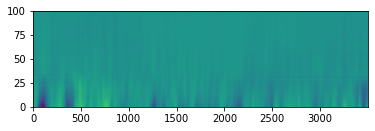

In [68]:
plt.imshow(corrected_chunk)
plt.gca().set_aspect(10)
plt.ylim(0,100)

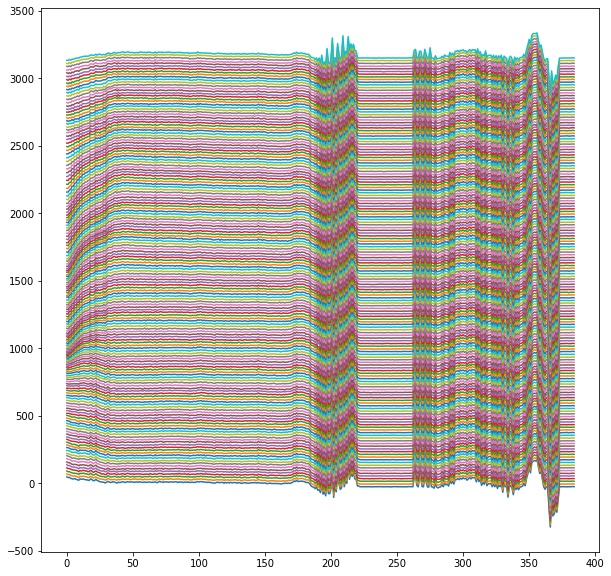

In [69]:
plt.figure(figsize=(10,10))
for ch in range(160):
    plt.plot(corrected_chunk[:,ch]+(ch*20))

In [70]:
corrected_chunk

array([[  45.5,   47.5,   49.5, ...,   16.5,   13.5,   16.5],
       [  41. ,   42. ,   44. , ...,   14. ,   13. ,   16. ],
       [  43. ,   44. ,   45. , ...,    6. ,    8. ,    9. ],
       ...,
       [ -27. ,  -27. ,  -26. , ..., -290. , -290. , -290. ],
       [ -25. ,  -25. ,  -25. , ..., -199. , -200. , -200. ],
       [ -27. ,  -27. ,  -26. , ...,  -34. ,  -34. ,  -33. ]])

In [71]:
corrected_chunk.T.shape

(3500, 385)

(-150.0, 150.0)

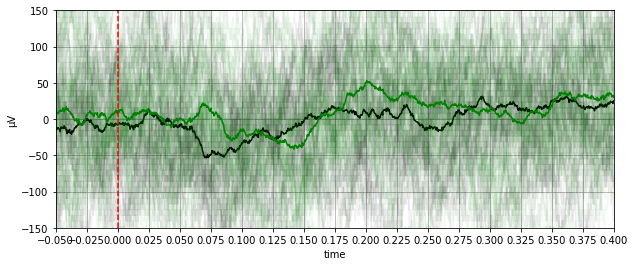

In [73]:
plt.figure(figsize=(10,4))
ch=50
respones_d = np.zeros((np.shape(dark)[0],2500,385))
for i,t in enumerate(dark):
    t = int(t * 2500)
    chunk = lfp[t-500:t+2000,:]
    corrected_chunk = chunk-np.median(chunk,axis=0)
    corrected_chunk = corrected_chunk.T - np.median(corrected_chunk[:,135:160],axis=1)
    corrected_chunk=1e6*corrected_chunk.T/(512.*lfp_gain)
    respones_d[i,:,:]=corrected_chunk
    plt.plot(np.linspace(-0.2,0.8,2500),corrected_chunk[:,ch],color='k',alpha=0.05)
plt.plot(np.linspace(-0.2,0.8,2500),np.mean(respones_d,axis=0)[:,ch],color='k')

ch=50
respones_b = np.zeros((np.shape(bright)[0],2500,385))
for i,t in enumerate(bright):
    t = int(t * 2500)
    chunk = lfp[t-500:t+2000,:]
    corrected_chunk = chunk-np.median(chunk,axis=0)
    corrected_chunk = corrected_chunk.T - np.median(corrected_chunk[:,135:160],axis=1)
    corrected_chunk=1e6*corrected_chunk.T/(512.*lfp_gain)
    respones_b[i,:,:]=corrected_chunk
    plt.plot(np.linspace(-0.2,0.8,2500),corrected_chunk[:,ch],color='g',alpha=0.05)
plt.plot(np.linspace(-0.2,0.8,2500),np.mean(respones_b,axis=0)[:,ch],color='g')
plt.gca().axvline(0,ls='--',color='r')
plt.ylabel('µV')
plt.xlabel('time')
plt.xticks(np.linspace(-0.2,0.8,21))
plt.grid()
plt.xlim(-0.05,0.4);plt.xticks(np.linspace(-0.05,0.4,19))
plt.ylim(-150,150)
# plt.gcf().savefig(os.path.join(recording_folder,'figs','flash_evoked_VEP_zoomed.png'),format='png',dpi=600)

In [74]:
np.save(os.path.join(recording_folder,'bright_VEP_imec'+str(probe)),respones_b)
np.save(os.path.join(recording_folder,'dark_VEP_imec'+str(probe)),respones_d)

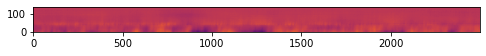

In [53]:
f,ax=plt.subplots(figsize=(8,2))
# ax.set_aspect(400)
cm = ax.imshow(np.mean(respones_b,axis=0).T,cmap=plt.cm.inferno,clim=(-500,500))
ax.set_ylim(0,140)
# plt.colorbar(cm)
plt.gcf().savefig(os.path.join(recording_folder,'figs','flash_evoked_VEP_depth.png'),format='png',dpi=600)

In [405]:
bright_VEP = np.mean(respones_b,axis=0).T[:120][:,500:1250]
dark_VEP = np.mean(respones_d,axis=0).T[:120][:,500:1250]

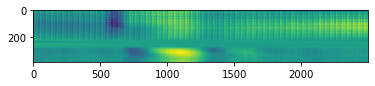

In [406]:
plt.imshow(np.mean(respones_b,axis=0).T[::-1])

In [407]:
dark_VEP.shape

(120, 750)

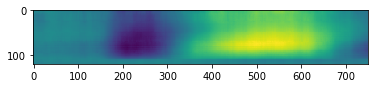

In [408]:
plt.imshow(dark_VEP)

In [409]:
bright_VEP.shape

(120, 750)

In [433]:
import seaborn as sns
sns.set_palette(sns.color_palette('vridis',60))

ValueError: vridis is not a valid palette name

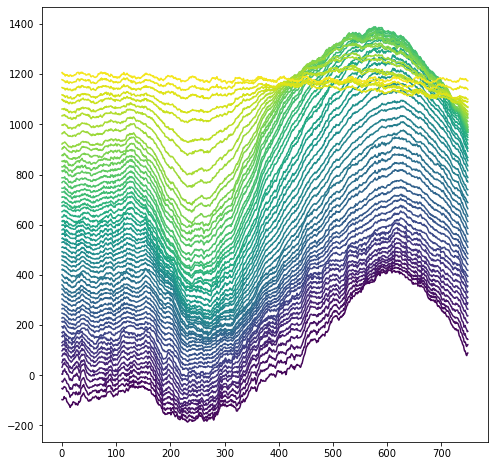

In [411]:
b = np.array(bright_VEP[1::2,:] + bright_VEP[1::2])/2.
plt.figure(figsize=(8,8))
for ch in range(60): plt.plot(b[ch]+ch*20)

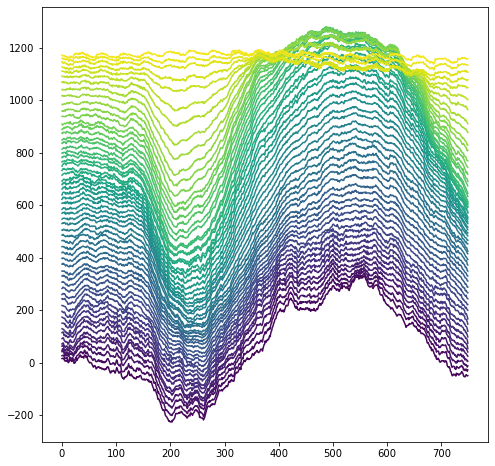

In [412]:
d = np.array(dark_VEP[1::2,:] + dark_VEP[1::2])/2.
plt.figure(figsize=(8,8))
for ch in range(60): plt.plot(d[ch]+ch*20)

## Calculate Current Source Density
iCSD https://www.sciencedirect.com/science/article/pii/S0165027005004541?via%3Dihub
<br>
First, import and set up standard for all recording

In [456]:
from dlab import icsd
import neo
import quantities as pq
from dlab.generalephys import option234_positions

for symbol, prefix, definition, u_symbol in zip(
    ['siemens', 'S', 'mS', 'uS', 'nS', 'pS'],
    ['', '', 'milli', 'micro', 'nano', 'pico'],
    [pq.A/pq.V, pq.A/pq.V, 'S', 'mS', 'uS', 'nS'],
    [None, None, None, None, u'µS', None]):
    if type(definition) is str:
        definition = lastdefinition / 1000
    if not hasattr(pq, symbol):
        setattr(pq, symbol, pq.UnitQuantity(
            prefix + 'siemens',
            definition,
            symbol=symbol,
            u_symbol=u_symbol))
    lastdefinition = definition
    
    

In [457]:
#specify conductivities and assumed source geometry
diam = 300E-6 * pq.m                              # [m]
h = 100E-6 * pq.m                                 # [m]
sigma = 0.3 * pq.S / pq.m                         # [S/m] or [1/(ohm*m)]
sigma_top = 0.2 * pq.S / pq.m                     # [S/m] or [1/(ohm*m)]


set up for this recording

In [458]:
#specify geometry
z_data = option234_positions[:120][:,1][::-1][::2] * 1e-6 * pq.m  # [m]
# z_data[1::2] = z_data[1::2]+0.000005* pq.m   

define function `update_csd_params()` for updating csd inputs to use different LFP, used below (code may be hidden)

In [459]:
# Input dictionaries for each method
def update_csd_params():
    delta_input = {
        'lfp' : lfp_data,
        'coord_electrode' : z_data,
        'diam' : diam,          # source diameter
        'sigma' : sigma,        # extracellular conductivity
        'sigma_top' : sigma,    # conductivity on top of cortex
        'f_type' : 'gaussian',  # gaussian filter
        'f_order' : (6, 3),     # 3-point filter, sigma = 1.
    }
    step_input = {
        'lfp' : lfp_data,
        'coord_electrode' : z_data,
        'diam' : diam,
        'h' : h,                # source thickness
        'sigma' : sigma,
        'sigma_top' : sigma,
        'tol' : 1E-12,          # Tolerance in numerical integration
        'f_type' : 'gaussian',
        'f_order' : (3, 1),
    }
    spline_input = {
        'lfp' : lfp_data,
        'coord_electrode' : z_data,
        'diam' : diam,
        'sigma' : sigma,
        'sigma_top' : sigma,
        'num_steps' : 60,      # Spatial CSD upsampling to N steps
        'tol' : 1E-12,
        'f_type' : 'gaussian',
        'f_order' : (3, 3),
    }
    std_input = {
        'lfp' : lfp_data,
        'coord_electrode' : z_data,
        'sigma' : sigma,
        'f_type' : 'gaussian',
        'f_order' : (3, 1),
    }
    return dict(
    delta_icsd = icsd.DeltaiCSD(**delta_input),
    step_icsd = icsd.StepiCSD(**step_input),
    spline_icsd = icsd.SplineiCSD(**spline_input),
#     std_csd = icsd.StandardCSD(**std_input),
)
# update_csd_params()

Create the different CSD-method class instances. <br> We use the class methods
get_csd() and filter_csd() below to get the raw and spatially filtered
versions of the current-source density estimates.<br>Options:
-    delta_icsd = icsd.DeltaiCSD(**delta_input),
-    step_icsd = icsd.StepiCSD(**step_input),
-    spline_icsd = icsd.SplineiCSD(**spline_input),
-     std_csd = icsd.StandardCSD(**std_input),



#### dark flashes

discrete filter coefficients: 
b = [ 0.707 0.882 0.986 0.986 0.882 0.707 ], 
a = [ 5.151 ]


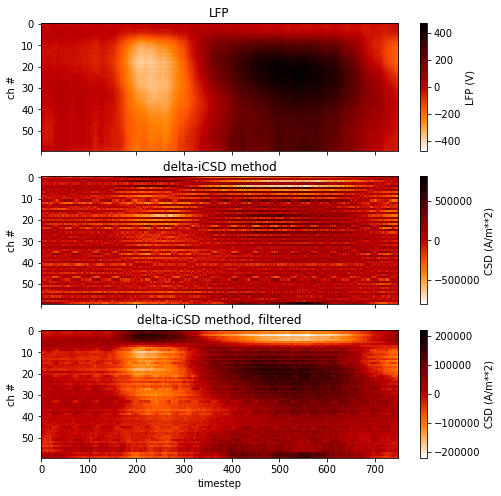

In [460]:
lfp_data = d[::-1] * pq.V        # [uV]  #prepare lfp data for use, by changing the units to SI and append quantities,
csd_dict = update_csd_params()
csd_obj = csd_dict['delta_icsd']
fig,axes = icsd.plot_csd(lfp_data,csd_obj)
plt.gcf().savefig(os.path.join(recording_folder,'figs','flash_evoked_CSD_depth_dark.png'),format='png',dpi=600)

#### bright flashes

/Users/danieljdenman/opt/anaconda3/lib/python3.7/site-packages/quantities/quantity.py:342: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(other, self)


discrete filter coefficients: 
b = [ 0.707 0.882 0.986 0.986 0.882 0.707 ], 
a = [ 5.151 ]


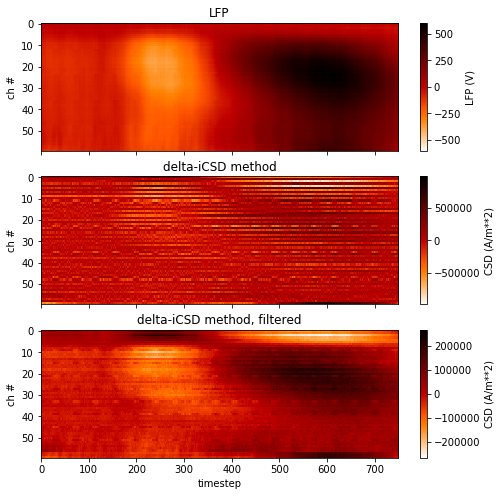

In [461]:
lfp_data = b[::-1] * pq.V        # [uV]  #prepare lfp data for use, by changing the units to SI and append quantities,
csd_dict = update_csd_params()
csd_obj = csd_dict['delta_icsd']
fig,axes = icsd.plot_csd(lfp_data,csd_obj)
plt.gcf().savefig(os.path.join(recording_folder,'figs','flash_evoked_CSD_depth_bright.png'),format='png',dpi=600)

<br>
<br>
<br>
<br>
<br>
<br><br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br><br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br><br>
<br>
<br>
<br>

In [218]:
df_units.index

Index(['7', '9', '20', '21', '31', '37', '42', '275', '277', '278', '279',
       '285', '287', '288', '1', '14', '18', '19', '20', '28', '31', '34',
       '35', '36', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
       '49', '51', '55', '56', '61', '62', '66', '76', '77', '78', '82', '88',
       '97', '109', '113', '121', '130', '132', '136', '142', '143', '145',
       '146', '147', '148', '149', '154', '155', '157', '171', '175', '176',
       '177', '261', '293', '302', '303', '304', '308', '309', '311', '312',
       '313', '315', '317', '318', '321', '323', '324', '328', '329', '331'],
      dtype='object')

In [213]:
from dlab.psth_and_raster import psth_line

In [236]:
df_units[df_units.index=='7'].times.values[0]

array([  31.54923333,   32.5144    ,   32.54776667, ..., 1838.9495    ,
       1838.9846    , 1839.0496    ])

In [243]:
import matplotlib 
matplotlib.rcParams.update({'figure.max_open_warning': 0})

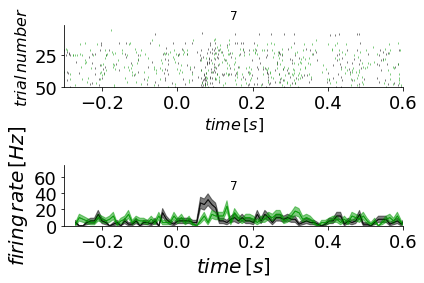

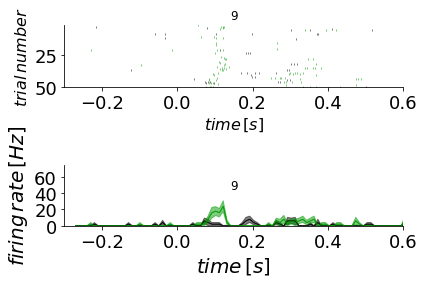

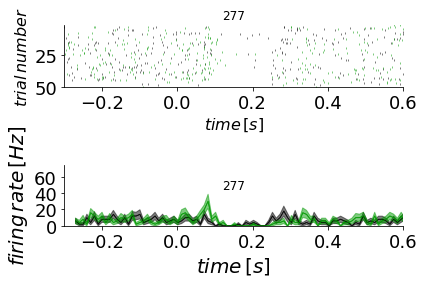

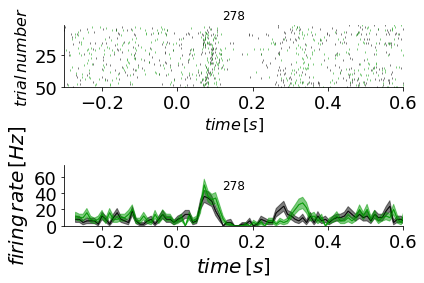

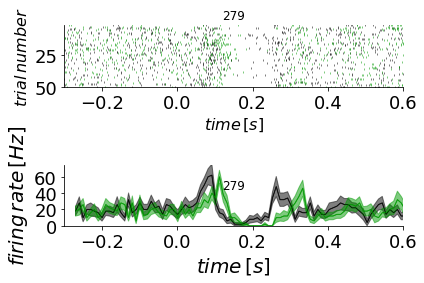

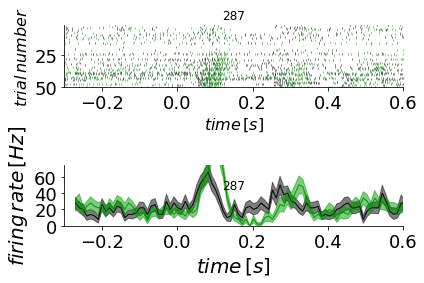

In [304]:
for unit in ['7','9','277','278','279','287']:#for unit in df_units.index::#for unit in df_units.index:
    f,ax = plt.subplots(2,1)
    raster(df_units[df_units.index==unit].times.values[0],dark,pre=0.3,post=0.6,name=unit,axes=ax[0],color='k')
    raster(df_units[df_units.index==unit].times.values[0],bright,pre=0.3,post=0.6,name=unit,axes=ax[0],color='#009900')
    ax[0].set_xlim(-0.3,0.6)
    psth_line(df_units[df_units.index==unit].times.values[0],dark,pre=0.3,post=0.6,binsize=0.010,name=unit,axes=ax[1])
    psth_line(df_units[df_units.index==unit].times.values[0],bright,pre=0.3,post=0.6,binsize=0.010,name=unit,axes=ax[1],color='#009900')
    plt.tight_layout()
    plt.gcf().savefig(os.path.join(recording_folder,'figs',unit+'_flash_evoked.png'),format='png',dpi=600)

In [246]:
from dlab.psth_and_raster import raster

In [279]:
scene_starts = nwb['intervals']['trials']['start_time'][320:320+2950][::118]

In [280]:
np.diff(scene_starts)

array([11.7994 , 11.79939, 11.79934, 11.79891, 11.79955, 11.79957,
       11.79935, 11.79904, 11.79984, 11.79962, 11.79861, 11.79976,
       11.79931, 11.79936, 11.79877, 11.79982, 11.7994 , 11.79933,
       11.79937, 11.79873, 11.79988, 11.79944, 11.79931, 11.79933])

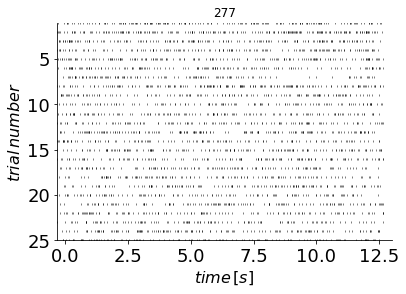

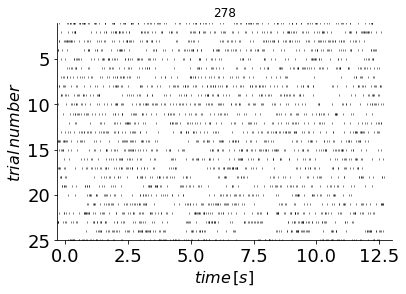

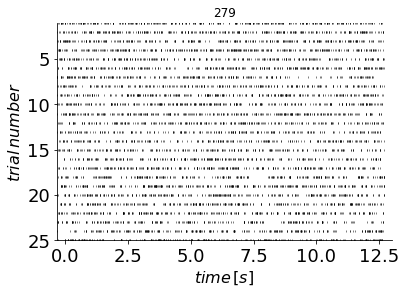

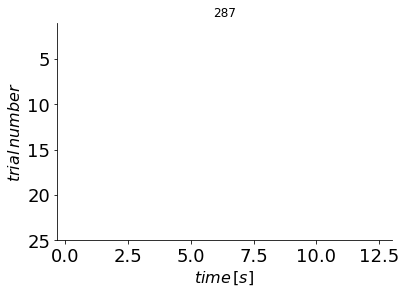

In [281]:
for unit in ['277','278','279','287']:#for unit in df_units.index:
    f,ax = plt.subplots(1,1)
    raster(df_units[df_units.index==unit].times.values[0],scene_starts,pre=0.3,post=12.,name=unit,axes=ax,color='k')
#     psth_line(df_units[df_units.index==unit].times.values[0],bright,pre=0.3,post=0.6,binsize=0.010,name=unit,axes=ax,color='#009900')

In [297]:
grating_starts = nwb['intervals']['trials']['start_time'][100:320]
stim='gratings'
info = [stimuli[stim]['bgsweeptable'][ind] for ind in stimuli[stim]['bgsweeporder']]
sf08 = np.array(info)[:,3]==0.08
sf16 = np.array(info)[:,3]==0.16

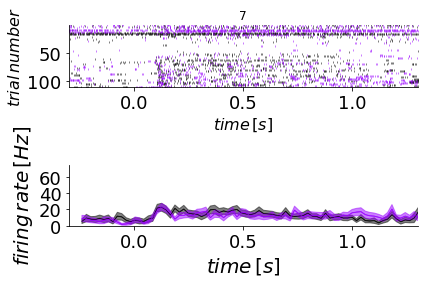

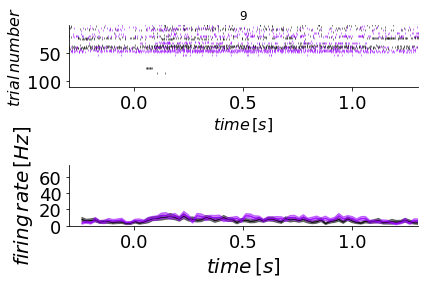

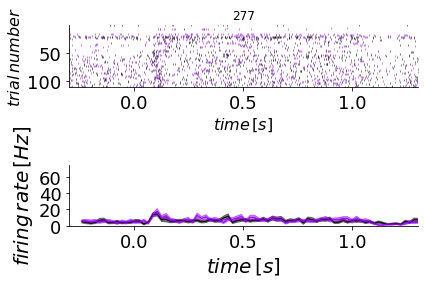

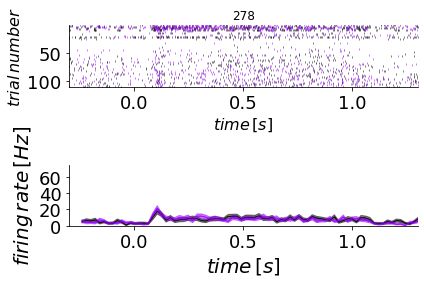

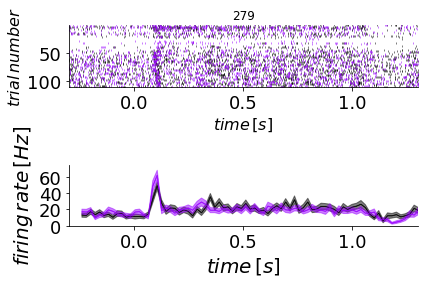

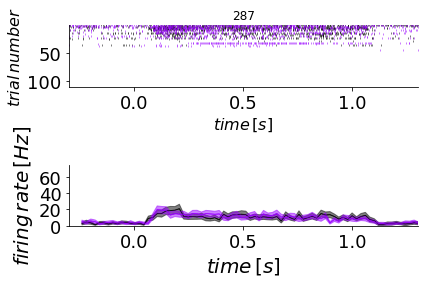

In [306]:
for unit in ['7','9','277','278','279','287']:#df_units.index:
    f,ax = plt.subplots(2,1)
    raster(df_units[df_units.index==unit].times.values[0],grating_starts[sf08],pre=0.3,post=1.3,name=unit,axes=ax[0],color='k')
    raster(df_units[df_units.index==unit].times.values[0],grating_starts[sf16],pre=0.3,post=1.3,name=unit,axes=ax[0],color='#9900ff')
    ax[0].set_xlim(-0.3,1.3)
    psth_line(df_units[df_units.index==unit].times.values[0],grating_starts[sf08],pre=0.3,post=1.3,binsize=0.02,axes=ax[1],color='k')
    psth_line(df_units[df_units.index==unit].times.values[0],grating_starts[sf16],pre=0.3,post=1.3,binsize=0.02,axes=ax[1],color='#9900ff')
    plt.tight_layout()
    plt.gcf().savefig(os.path.join(recording_folder,'figs',unit+'_grating_evoked.png'),format='png',dpi=600)

In [309]:
df_units['rate'] = [np.shape(times)[0]/(times[-1]- times[0]) for times in df_units.times]

In [310]:
df_units['rate']

7       8.668878
9       4.348074
20      5.110550
21      1.040750
31      4.072674
         ...    
323     0.178778
324     1.899373
328    11.068357
329     3.846458
331     5.275019
Name: rate, Length: 86, dtype: float64

In [311]:
import seaborn as sns

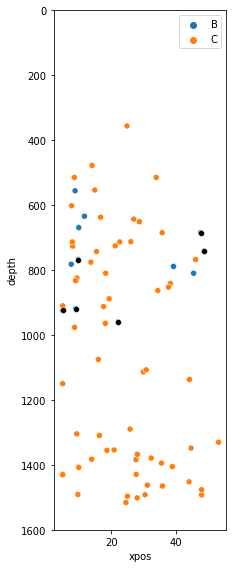

In [345]:
plt.figure(figsize=(8,8))
g = sns.scatterplot(
    data=df_units,
    x="xpos", y="depth",
    hue="probe", sizes=(40, 80)
)

g2 = sns.scatterplot(
    data=df_units[df_units.index.isin(['7','9','277','278','279','287'])],
    x="xpos", y="depth",color='k',
    ax=plt.gca()
)
plt.gca().set_ylim(1600,0)
plt.gca().set_aspect(0.1)
plt.tight_layout()
plt.gcf().savefig(os.path.join(recording_folder,'figs','units.png'),format='png',dpi=600)

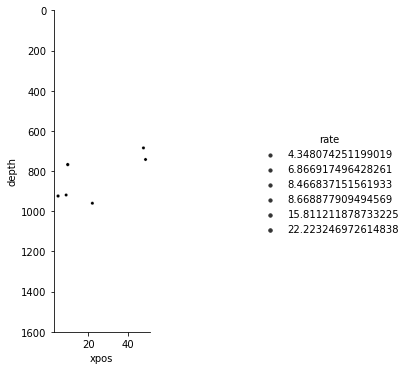

In [328]:
g = sns.relplot(
    data=df_units[df_units.index.isin(['7','9','277','278','279','287'])],
    x="xpos", y="depth",
    size="rate", sizes=(10, 12),color='k',
)
plt.gca().set_ylim(1600,0)
plt.gca().set_aspect(0.1)